In [21]:
# imports

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Masking, Embedding

import random

import os
import pandas as pd
import numpy as np

from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
sia = SIA()

import nltk
#file for punkt splitter
nltk.download('punkt');
#file for vader sentiment
nltk.download('vader_lexicon');

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

plt.rcParams["figure.figsize"]=20,20
%matplotlib inline

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\emiel\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [11]:
series_len = 100
mask_value = -10
max_len = 0

def text_to_sentiments(text):
    sentences = nltk.tokenize.sent_tokenize(text)
    scores = np.vstack([ np.array(list((sia.polarity_scores(s)).values())) for s in sentences]) #list of scores per sentence
    return scores

def rating_to_score_array(t):
    return np.array([int(t=='FALSE'), int(t=='mostly false'), int(t=='mixture'), int(t=='mostly true'), int(t=='TRUE')])

In [18]:

dataset_path = os.path.join("sources", "snopes_checked_v02.csv")
dataset_load = pd.read_csv(dataset_path, encoding='ANSI')

dataset = pd.DataFrame({
                        'title': dataset_load['article_title_phase2'],
                        'body': dataset_load['original_article_text_phase2'],
                        'category': dataset_load['article_category_phase1'],
                        'descr_rating': dataset_load['fact_rating_phase1']
                        })

df = pd.DataFrame(columns = ['scores', 'veracity'])

df['scores'] = dataset.body.apply(text_to_sentiments)
df['veracity'] = dataset.descr_rating.apply(rating_to_score_array)

df.to_csv(os.path.join('out', 'truefake_mcintire.csv'), index=False)


X = np.array(df['scores'].to_list())
X = tf.keras.preprocessing.sequence.pad_sequences(X, maxlen=series_len, padding='post', truncating='pre', dtype='float64', value=-10)
  
y= np.array(df['veracity'].to_list())

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape

(234, 100, 4)

In [30]:
model = None

model = Sequential()

model.add(Masking(mask_value=-10,
                  input_shape=(100, 4)))

model.add(LSTM(100,return_sequences=True))

model.add(LSTM(50))

model.add(Dense(5, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

print(model.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
masking_3 (Masking)          (None, 100, 4)            0         
_________________________________________________________________
lstm_6 (LSTM)                (None, 100, 100)          42000     
_________________________________________________________________
lstm_7 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 255       
Total params: 72,455
Trainable params: 72,455
Non-trainable params: 0
_________________________________________________________________
None


In [31]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=250, batch_size=2)

Epoch 1/250
117/117 [==============================] - 9s 74ms/step - loss: 1.6216 - accuracy: 0.2009 - val_loss: 1.6034 - val_accuracy: 0.2564
Epoch 2/250
117/117 [==============================] - 6s 50ms/step - loss: 1.6101 - accuracy: 0.2009 - val_loss: 1.5910 - val_accuracy: 0.2564
Epoch 3/250
117/117 [==============================] - 6s 50ms/step - loss: 1.6062 - accuracy: 0.2137 - val_loss: 1.5939 - val_accuracy: 0.2436
Epoch 4/250
117/117 [==============================] - 6s 50ms/step - loss: 1.6028 - accuracy: 0.2094 - val_loss: 1.5899 - val_accuracy: 0.2564
Epoch 5/250
117/117 [==============================] - 6s 50ms/step - loss: 1.5996 - accuracy: 0.2393 - val_loss: 1.5890 - val_accuracy: 0.2436
Epoch 6/250
117/117 [==============================] - 6s 51ms/step - loss: 1.6023 - accuracy: 0.2479 - val_loss: 1.5892 - val_accuracy: 0.2821
Epoch 7/250
117/117 [==============================] - 6s 52ms/step - loss: 1.6017 - accuracy: 0.2393 - val_loss: 1.5870 - val_accuracy:

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


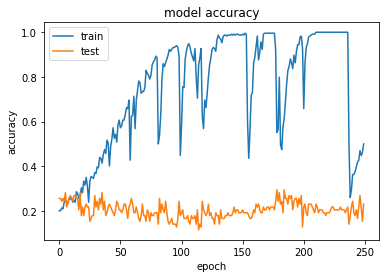

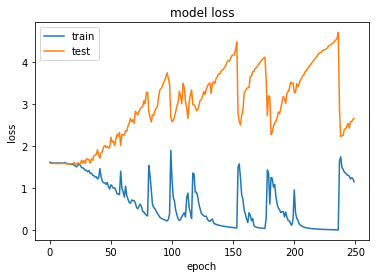

In [32]:
# Thanks Jason Brownlee
# https://machinelearningmastery.com/display-deep-learning-model-training-history-in-keras/
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()